# Rooster 評估任務二

本 Notebook 用來支援 A2 報告：  
1. 載入資料與基本檢查  
2. 資料品質與異常值檢視  
3. 多表結構與欄位檢查  
4. 訂單金額分布與異常值  
5. 客戶層級聚合與特徵工程  
6. 回頭客預測模型（PyCaret）  
7. 模型解讀與圖表（供報告截圖使用）

請將 `rooster_a2.xlsx` 與此 notebook 放在同一資料夾。

## 1. 載入套件與資料
- 載入 Python 套件（pandas、seaborn、matplotlib、pycaret 等）
- 設定繪圖風格
- 讀取 `rooster_a2.xlsx` 中的多個工作表

In [33]:
# 1.1 載入常用套件
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

# 檢查環境中是否有 pycaret（用來做分類模型）
from pycaret.classification import *

# Checking versions of the libraries
print("Library Versions:")
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("numpy:", np.__version__)
print("\n")

# 繪圖風格設定（讓所有圖表一致、適合投影片）
sns.set_theme(style="white", rc={'figure.figsize': (12, 6)})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.0})

# 讀取 Excel 檔案中的各個工作表
file_path = "rooster_a2.xlsx"   

products   = pd.read_excel(file_path, sheet_name="products")
orders     = pd.read_excel(file_path, sheet_name="orders")
orderlines = pd.read_excel(file_path, sheet_name="orderlines")
customers  = pd.read_excel(file_path, sheet_name="customers")

# 檢查基本維度（列數 & 欄位數）
shape_summary = pd.DataFrame({
    "Dataset": ["products", "orders", "orderlines", "customers"],
    "Rows":    [products.shape[0], orders.shape[0], orderlines.shape[0], customers.shape[0]],
    "Columns": [products.shape[1], orders.shape[1], orderlines.shape[1], customers.shape[1]]
})

print("=== Dataset Shape Summary ===")
shape_summary.index = shape_summary.index + 1  # 從 1 開始編號
print(shape_summary)

# 欄位結構檢視函式
def print_numbered_columns(df, name):
    print(f"=== {name} ===")
    for idx, col in enumerate(df.columns, start=1):
        print(f"{idx}. {col}")
    print("\n")


# 1.2 欄位結構（Columns）與資料品質檢查
# 檢視欄位結構
print("\n")
print_numbered_columns(orders, "Orders")
print_numbered_columns(orderlines, "Orderlines")            
print_numbered_columns(products, "Products")
print_numbered_columns(customers, "Customers")

# 缺失值檢查
def missing_summary(df, name):
    """
    df   : DataFrame
    name : 表名稱 (字串)
    """
    missing = df.isnull().sum().to_frame(name="Missing Count")
    missing["Total Rows"] = len(df)
    missing["Missing %"] = (missing["Missing Count"] / len(df) * 100).round(2)
    
    # 增加總缺失數（欄位合計）
    total_missing = missing["Missing Count"].sum()
    print(f"=== {name} Missing Summary ===")
    print(f"總缺失量（所有欄位加總）：{total_missing}")
    print()
    
    return missing

# 分別產生 summary
products_missing     = missing_summary(products, "Products")
orders_missing       = missing_summary(orders, "Orders")
orderlines_missing   = missing_summary(orderlines, "Orderlines")
customers_missing    = missing_summary(customers, "Customers")

# 顯示成果
print("\n=== Missing Values Summary ===")
print("Products Missing Values:\n", products_missing)
print("\nOrders Missing Values:\n", orders_missing)
print("\nOrderlines Missing Values:\n", orderlines_missing)
print("\nCustomers Missing Values:\n", customers_missing)

# 重複值檢查
print("\n=== Duplicates Summary ===")
print("products duplicates:", products.duplicated().sum())
print("orders duplicates:", orders.duplicated().sum())
print("orderlines duplicates:", orderlines.duplicated().sum())
print("customers duplicates:", customers.duplicated().sum())

# 欄位資料型態檢查
tables = {
    "products": products,
    "orders": orders,
    "orderlines": orderlines,
    "customers": customers
}

def dtype_summary(df, name):
    out = (
        df.dtypes
          .astype(str)
          .to_frame("dtype")
          .reset_index()
          .rename(columns={"index": "column"})
    )
    print(f"\n=== {name} – Data Types ===")
    display(out)
    return out

products_dtypes   = dtype_summary(products,   "products")
orders_dtypes     = dtype_summary(orders,     "orders")
orderlines_dtypes = dtype_summary(orderlines, "orderlines")
customers_dtypes  = dtype_summary(customers,  "customers")


Library Versions:
pandas: 2.1.4
seaborn: 0.13.2
numpy: 1.26.4


=== Dataset Shape Summary ===
      Dataset   Rows  Columns
1    products    226       12
2      orders  10541       16
3  orderlines  27795        8
4   customers   8465        5


=== Orders ===
1. order_number
2. customer_email
3. order_date
4. payment_method_title
5. shipping_method_title
6. coupon_code
7. coupon_count
8. origin
9. order_subtotal
10. order_total
11. order_total_tax
12. order_shipping
13. order_refund
14. cart_discount
15. discount_amount
16. discount_amount_tax


=== Orderlines ===
1. order_number
2. product_id
3. variation_id
4. sku
5. line_id
6. qty_minus_refund
7. item_price
8. item_price_before_discount


=== Products ===
1. product_id
2. range
3. product_type
4. category
5. product_name_main
6. product_name
7. size
8. variation_id
9. sku
10. price
11. type
12. colour


=== Customers ===
1. billing_email
2. customer_first_order_date
3. customer_last_order_date
4. customer_total_orders
5. customer_t

,column,dtype
0,product_id,object
1,range,object
2,product_type,object
3,category,object
4,product_name_main,object
5,product_name,object
6,size,object
7,variation_id,object
8,sku,object
9,price,float64



=== orders – Data Types ===


,column,dtype
0,order_number,object
1,customer_email,object
2,order_date,object
3,payment_method_title,object
4,shipping_method_title,object
5,coupon_code,object
6,coupon_count,int64
7,origin,object
8,order_subtotal,float64
9,order_total,float64



=== orderlines – Data Types ===


,column,dtype
0,order_number,object
1,product_id,object
2,variation_id,object
3,sku,object
4,line_id,int64
5,qty_minus_refund,int64
6,item_price,float64
7,item_price_before_discount,float64



=== customers – Data Types ===


,column,dtype
0,billing_email,object
1,customer_first_order_date,object
2,customer_last_order_date,object
3,customer_total_orders,int64
4,customer_total_spent,float64


## 2. 資料品質檢查

針對 `orders` 訂單資料 進行初步資料品質檢查，包含欄位分布、異常值、缺失值與商業語意判讀。\
特別聚焦以下兩個與後續模型高度相關的欄位：
- order_total（訂單金額）：檢查分布是否右偏與是否存在異常值（例如 0 金額訂單）。
- coupon_code（優惠券代碼）：缺失值實際代表「未使用優惠券」，需要轉換成行為特徵。

主要檢查內容
- 以描述統計了解訂單金額分布
- 使用 99th percentile 限制極端值並繪製 histogram
- 判斷 order_total = 0 的訂單是否需要排除
- 分析 coupon_code 的缺失比例，並建立 has_coupon 行為特徵

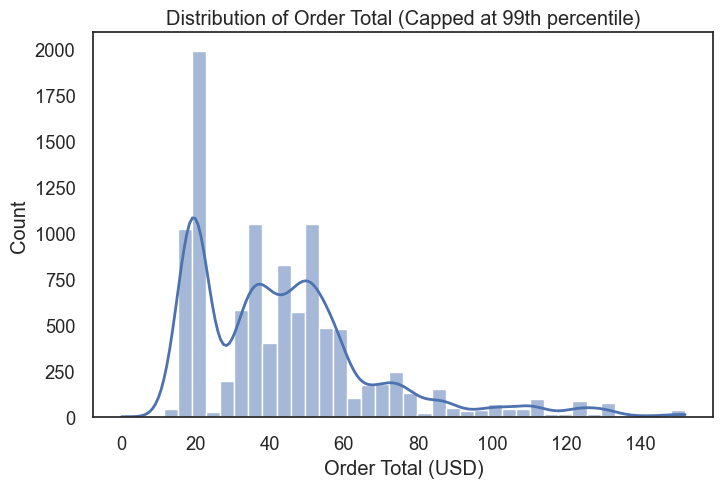

order_total = 0 的訂單數量： 8


=== Coupon Code Missing Analysis ===

coupon_code 缺失比例（＝未使用優惠券）：70.96%

優惠券使用比例：

    比例  proportion
未使用優惠券     0.70961
 使用優惠券     0.29039


In [50]:
# 2.1 訂單金額分布（order_total）
# 確保 order_total 是數值
orders["order_total"] = pd.to_numeric(orders["order_total"], errors="coerce")
orders["order_total"].describe(percentiles=[0.25, 0.5, 0.75])

# Histogram – 訂單金額分布
# 2.2 畫出訂單金額的分布圖，快速看右偏與極端值
# 使用 99 百分位數作為上限來過濾極端值
q99 = orders["order_total"].quantile(0.99)
subset = orders[orders["order_total"] <= q99]

plt.figure(figsize=(8,5))
sns.histplot(subset["order_total"], bins=40, kde=True)
plt.xlabel("Order Total (USD)")
plt.title("Distribution of Order Total (Capped at 99th percentile)")
plt.show()

# 2.3 檢查金額為 0 的訂單數量
zero_orders = orders[orders["order_total"] == 0]
print("order_total = 0 的訂單數量：", zero_orders.shape[0])

# 註解：
# - 這類訂單可能是取消、測試或資料輸出問題
# - 依照分析目的決定是否排除（例如：計算平均訂單價值時通常會排除）
print("\n")


# 2.4 檢查 coupon_code 缺失比例（＝未使用優惠券）
print("=== Coupon Code Missing Analysis ===\n")

# 缺失比例（代表未使用優惠券）
coupon_null_rate = orders["coupon_code"].isna().mean()
print(f"coupon_code 缺失比例（＝未使用優惠券）：{coupon_null_rate:.2%}\n")

# 建立是否使用優惠券欄位
orders["has_coupon"] = orders["coupon_code"].notna()

# 製作「使用 vs 未使用」比例表（排版不歪）
coupon_usage_df = (
    orders["has_coupon"]
    .value_counts(normalize=True)
    .rename({True: "使用優惠券", False: "未使用優惠券"})
    .reset_index()
    .rename(columns={"index": "是否使用優惠券", "has_coupon": "比例"})
)

print("優惠券使用比例：\n")
print(coupon_usage_df.to_string(index=False))


## 3. 顧客層級聚合（Customer-Level Aggregation）
 將訂單從「單筆訂單」彙整到「每位顧客一筆」的 customer_orders 表：
 - 先依 order_date 對 orders 排序，確保能正確取得「首購」資訊
 - 以 customer_email 為 key 計算：
   - order_count：每位顧客的訂單總數
   - repeat_customer：是否為回購顧客（order_count > 1）
   - first_order_acquisition_channel：首購時的來源渠道（origin）
   - first_order_coupon_used：首購是否使用優惠券（has_coupon）
 這個顧客層級資料表將作為後續回購預測模型與顧客分析的主要輸入。

In [53]:
# 3.1 按時間排序訂單
orders_sorted = orders.sort_values("order_date")

# 計算客戶訂單數量
order_count = orders_sorted.groupby("customer_email")["order_number"].count()

# 判斷是否為回購顧客
repeat_customer = (order_count > 1)

# 取得顧客的首購來源（Acquisition Channel）
first_order_acquisition_channel = orders_sorted.groupby("customer_email")["origin"].first()

# 取得首購是否使用優惠券
first_order_coupon_used = orders_sorted.groupby("customer_email")["has_coupon"].first()

# 合併成 customer_orders 表
customer_orders = pd.DataFrame({
    "order_count": order_count,
    "repeat_customer": repeat_customer,
    "first_order_acquisition_channel": first_order_acquisition_channel,
    "first_order_coupon_used": first_order_coupon_used
})

customer_orders.head()

,order_count,repeat_customer,first_order_acquisition_channel,first_order_coupon_used
customer_email,,,,
eml_000360a4@gmail.example.net,1,False,Google,False
eml_0004e5dd@gmail.example.net,1,False,Direct,False
eml_0014d3d3@gmail.example.net,1,False,Shopping comparison,False
eml_0015d5a1@gmail.example.net,4,True,Facebook,False
eml_002246ad@gmail.example.net,1,False,Facebook,True


## 4. 描述性分析（渠道 × 訂單金額）
專注在 `orders` 層級：
- 觀察不同 `origin`（獲客來源）的訂單中位數與分布  
- 為後面「哪個渠道值得投資」的討論提供定量依據

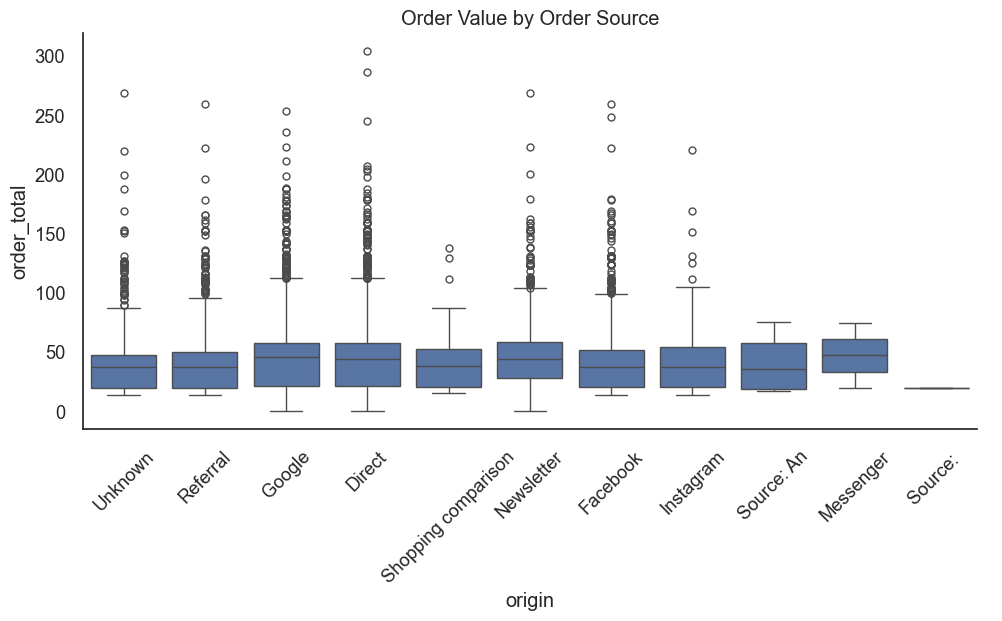

,origin,median,count
4,Messenger,47.240,2
2,Google,46.200,2381
5,Newsletter,44.450,764
0,Direct,44.400,2373
7,Shopping comparison,38.700,249
1,Facebook,37.700,1990
3,Instagram,37.500,164
10,Unknown,37.300,1373
6,Referral,37.055,1240
9,Source: An,35.435,4


In [22]:
# 4.1 以 boxplot 觀察各渠道的訂單金額分布
sns.catplot(
    data=orders,
    x="origin",
    y="order_total",
    kind="box",
    aspect=2
).set_xticklabels(rotation=45)
plt.title("Order Value by Order Source")
plt.show()

# 4.2 計算各來源的訂單中位數與筆數
origin_summary = (
    orders
    .groupby("origin")["order_total"]
    .agg(["median", "count"])
    .reset_index()
    .sort_values("median", ascending=False)
)
origin_summary

## 5. 建立客戶層級資料 （repeat_customer）
- 將訂單（order）彙總到「客戶層級」
- 為每個客戶建立以下欄位：
  - `order_count`：總訂單數
  - `repeat_customer`：是否為回頭客（>1 筆訂單）
  - `first_order_acquisition_channel`：首購獲客來源
  - `first_order_coupon_used`：首購是否使用優惠券
這些特徵將用於：
- 描述性分析（回頭客比例、各渠道客戶品質）
- 後續的回頭客預測模型

In [23]:
# 5.1 先確保 order_date 是 datetime 格式，並排序
orders["order_date"] = pd.to_datetime(orders["order_date"])
orders_sorted = orders.sort_values(by=["customer_email", "order_date"])

# 5.2 聚合成 customer_orders
customer_orders = (
    orders_sorted
    .groupby("customer_email")
    .agg(
        order_count=("order_number", "nunique"),
        repeat_customer=("order_number", lambda x: x.nunique() > 1),
        first_order_acquisition_channel=("origin", "first"),
        first_order_coupon_code=("coupon_code", "first"),
    )
    .reset_index()
)

# 5.3 轉成「首購是否用券」的布林欄位
customer_orders["first_order_coupon_used"] = customer_orders["first_order_coupon_code"].notna()

customer_orders.head()

# 5.4 簡單看回頭客比例
repeat_rate = customer_orders["repeat_customer"].mean()
print(f"回頭客比例：約 {repeat_rate:.1%}")

# 5.5 依渠道看回頭客比例（後面寫報告時會用到）
channel_repeat = (
    customer_orders
    .groupby("first_order_acquisition_channel")["repeat_customer"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "repeat_rate", "count": "customer_count"})
    .sort_values("repeat_rate", ascending=False)
)

channel_repeat

回頭客比例：約 19.1%


,first_order_acquisition_channel,repeat_rate,customer_count
5,Newsletter,0.237885,454
7,Shopping comparison,0.236967,211
6,Referral,0.213691,1081
10,Unknown,0.207718,1218
3,Instagram,0.197183,142
1,Facebook,0.192084,1718
2,Google,0.174272,1819
0,Direct,0.164738,1815
4,Messenger,0.000000,1
8,Source:,0.000000,1


## 6. 基礎預測模型（PyCaret）
問題設定：
> 在客戶完成首購之後，根據「獲客渠道」與「是否使用優惠券」等資訊，
> 預測他是否會成為回頭客（repeat_customer）。

技術上：
- 這是一個二元分類（Binary Classification）問題
- 這裡使用 PyCaret 進行快速模型比較，並選擇邏輯回歸作為可解釋的基準模型

In [24]:
# 6.1 保留一部分資料當作最終 holdout（例如 20%）
holdout = customer_orders.sample(frac=0.2, random_state=220804)
train_data = customer_orders.drop(holdout.index)

print("train_data:", train_data.shape)
print("holdout:", holdout.shape)

# 6.2 設定 PyCaret 分類實驗
s = setup(
    data=train_data,
    target="repeat_customer",
    ignore_features=["customer_email", "first_order_coupon_code"],
    fix_imbalance=True,        # repeat_customer = True 的比例較低，用 SMOTE 平衡
    session_id=220804,
    verbose=False
)

# 6.3 比較多個模型（範例：使用 AUC 作為排序依據）
best_model = compare_models(
    sort="AUC",
    include=["lr", "rf", "dt", "ridge", "ada", "lda"]
)

# 6.4 指定邏輯回歸作為最終模型（方便解釋）
lr_model = create_model("lr")

# 6.5 在內部 test set 上評估模型表現
test_preds = predict_model(lr_model)
test_preds.head()


train_data: (6771, 6)
holdout: (1693, 6)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1780
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1600
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1220
ridge,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0060
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0060
lda,Linear Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0060


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,order_count,first_order_acquisition_channel,first_order_coupon_used,repeat_customer,prediction_label,prediction_score
609,1,Google,False,False,0,0.9976
6271,1,Facebook,False,False,0,0.9974
4205,1,Google,False,False,0,0.9976
2585,1,Facebook,False,False,0,0.9974
1959,1,Unknown,False,False,0,0.9975


## 7. 混淆矩陣與商業解讀
- 用 PyCaret 繪製混淆矩陣
- 以「行銷資源運用」的角度解讀四個格子：  
  - True Positive / True Negative  
  - False Positive / False Negative  

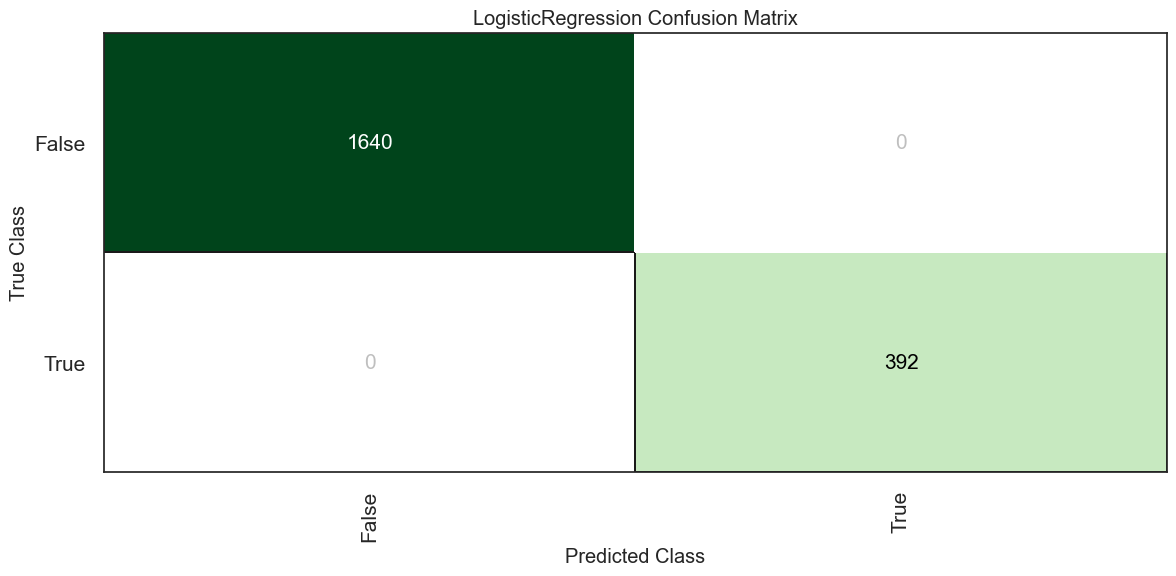

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


(1693, 8)


In [ ]:
# 7.1 在 PyCaret 的 test set 上產生混淆矩陣
plot_model(lr_model, plot="confusion_matrix")

# 7.2 用 holdout 進行最終評估
holdout_preds = predict_model(lr_model, data=holdout)
print(holdout_preds.shape)

# 7.3 混淆矩陣的商業解讀（寫成註解，以便未來製作公司簡報使用）

# False Positive（預測會回購，但實際不會）
# - 公司可能把行銷預算花在這些客戶身上（例如提供折扣、email 活動）
# - 但這些人最後沒有繼續購買 → 造成行銷資源浪費

# False Negative（實際會回購，但預測不會）
# - 這些本來「有機會成為忠誠客戶」的人，沒有被納入行銷名單
# - 可能錯失讓他們多買幾次的機會 → LTV 被低估

# 實務上：
# - 若 Rooster 想「多抓一些高價值客戶」，可以接受多一點 False Positive
# - 若行銷預算有限，則會希望降低 False Positive，集中火力在最有可能回購的人身上